# Adding mySql conneticon. Querying SQL with pandas

In [27]:
import pandas as pd
import mysql.connector
#from pyspark.sql import SparkSession

#appName = "PySpark MySQL Example - via mysql.connector"
#master = "local"

#spark = SparkSession.builder.master(master).appName(appName).getOrCreate()

connection = mysql.connector.connect(host='jum-ah-demo.just.sise', database='tpis', user='ignarvalme', password='sh7anhsKAH782s')
'#for getting server info and checking the connection works'
db_Info = connection.get_server_info()
print("Connected to MySQL Server version ", db_Info)
cursor = connection.cursor()

query = """
WITH tmp AS (

				SELECT
				Acc.ID AS Account_ID,
				Acc.username,
				Acc.last_active,
				tu.occupation,
				tpis_class.name AS Talitus,
				EV.id AS evaluations_ID,
				EV.created_at,
				EV.updated_at,
				EV.confirmer_id,
				EV.period,
				EV.deadline,
				EV.sender_account_id,
				EV.send_title,
				EV.start_date,
				
				ET.id AS evaluation_types_ID,
				ET.name AS evaluation_name,
				ET.`year`,
				ET.modify_date,
				EA.ID AS evaluation_answers_ID,
				-- COUNT(EA.ID) OVER(PARTITION BY EA.ID) AS Nr,
				EA.name AS evaluation_answers_name,
				NVL(cq.child_type, cq.parent_type ) AS question_input_type,
				
				-- cq.parent_type,
				-- cq.child_type ,
				-- parent_cq_id,
				--  cq.parent_title,
				--  cq.child_title,
				
				-- Kui sama evaluation_answers_ID on 2 tulemust, ehk on child küsimus olemas, siis kasuta pm seda. Distinct võtab lisa kirje ära
				CASE WHEN COUNT(EA.ID) OVER(PARTITION BY EA.ID) > 1 
						  AND cqr.title IS NULL 
					 THEN LAG(cqr.title) OVER(PARTITION BY EA.ID ORDER BY EA.ID )
					 
					 WHEN cqr.title IS NOT NULL THEN cqr.title 
					 ELSE cq.parent_title 
				END AS question_title,
					 
				TRIM(EA.value)  AS question_answer
				/*
				,cq.parent_name 
				,cq.parent_type
				,cq.parent_title 
				
				,cq.child_name 
				,cq.child_type 
				,cq.child_title */
				
				 ,NVL(cq.child_interviewer,cq.parent_interviewer ) AS interviewer
				 ,NVL(cq.child_employee,  cq.parent_employee) AS employee
				
				-- ,cqr.*
				/*,cqr.question_name
				,cqr.title */
				FROM evaluations EV 
				INNER JOIN evaluation_types ET ON EV.type_id =ET.ID
				INNER JOIN evaluation_answers EA ON EA.evaluation_id = EV.ID
				INNER JOIN accounts Acc ON Acc.ID=EV.Account_ID
				INNER JOIN tpis_user tu ON tu.account_id = Acc.ID
				INNER JOIN tpis_class  ON tpis_class.class_ID = tu.divisionID
				
				INNER JOIN (
							SELECT DISTINCT 
							
							 cq.id AS parent_cq_id, 
							 cq.conversation_type AS parent_conversation_type, 
							 cq.name AS parent_name, 
							 /*cq.parent_question,*/ 
							 cq.`type` AS parent_type, 
							 cq.title AS parent_title, 
							 cq.interviewer AS parent_interviewer, 
							 cq.employee AS parent_employee,
							 
							 cq1.id AS child_cq_id, 
							 cq1.conversation_type AS child_conversation_type, 
							 cq1.name AS child_name,  
							 cq1.`type` AS child_type, 
							 cq1.title AS child_title, 
							 cq1.mandatory AS child_mandatory, 
							 cq1.chief AS child_chief, 
							 cq1.interviewer AS child_interviewer, 
							 cq1.employee  AS child_employee
							 -- ,cq1.tutor
							 
							FROM conversation_questions cq LEFT JOIN conversation_questions cq1 ON
							cq.name = cq1.parent_question 
							AND cq.conversation_type = cq1.conversation_type 
							
							) cq ON -- NVL(cq.child_conversation_type,cq.parent_conversation_type) = EV.type_id 
							cq.parent_conversation_type = EV.type_id 
							 AND NVL(cq.child_name, cq.parent_name) = EA.name
							-- AND cq.parent_name = EA.name
				
				LEFT JOIN conversation_question_rows cqr ON 
				cq.parent_conversation_type = cqr.conversation_type
				-- NVL(cq.child_conversation_type,cq.parent_conversation_type) = cqr.conversation_type
				-- AND NVL(cq.child_name, cq.parent_name) = cqr.question_name
				AND cq.parent_name = cqr.question_name
				AND EA.row = cqr.row_id -- kui on alam küsimus siis row-d ka matchiksid.
				
				--  WHERE Acc.username = 'eesnimi66.perenimi66'
				-- ET.name LIKE 'Arenguvestluse küsimustik%' AND
				
				-- AND NVL(cq.child_type, cq.parent_type ) != 'text'
				
				-- AND  cqr.title like '%egide vaheline tööõhkkond ja koostöö on väga hea%' 
				
				 ORDER BY EA.ID 
				) 
				
				
SELECT DISTINCT
tmp.Account_ID,
tmp.username,
tmp.last_active,
tmp.occupation,
tmp.Talitus,
tmp.evaluations_ID,
tmp.created_at,
tmp.updated_at,
tmp.confirmer_id,
tmp.period,
tmp.deadline,
tmp.sender_account_id,
tmp.send_title,
tmp.start_date,
tmp.evaluation_types_ID,
tmp.evaluation_name,
tmp.`year`,
tmp.modify_date,
tmp.evaluation_answers_ID,
tmp.evaluation_answers_name,
tmp.question_input_type, 
REPLACE(NVL(tmp.question_title,evaluation_answers_name), '	', '') AS question_title,
tmp.question_answer,
tmp.interviewer,
tmp.employee

FROM tmp 
WHERE question_input_type IN ('line', 'text') 
 AND employee = 1
 -- AND evaluation_name = 'Arenguvestluste küsimustik töötajatele (2020)'
-- WHERE username = 'eesnimi66.perenimi66'
 AND NVL(tmp.question_title,evaluation_answers_name) LIKE '%Missugune koolitus aitaks sul paremini tööülesandeid täita praegu ja tulevikus%'
"""

df = pd.read_sql(query, con=connection)
#print(df)
connection.close()

Connected to MySQL Server version  5.5.5-10.5.13-MariaDB-log


C:\Program Files\Python39\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


# Selecting only answers and joinin all rows to one big string

In [28]:
question_answer_list = df['question_answer'].tolist()
# ' ' to not have things like this "kontorisPigem". And rahter like this "kontoris Pigem"
text_question_answer = ' '.join(question_answer_list)
print('DONE')

DONE


# Cleanup, lemmas and other NLTK stuff

In [38]:
from estnltk import Text
from nltk.corpus import stopwords
import re
import string

'#to remove commas and so on'
#def cleanup(s, chars):
  #  clean_strings = re.sub('[%s]' % chars, '', s).lower()
   # return clean_strings

# Adding my own stopswords, that I dont want add to stopwords text file
# my_stopwords = ['RIK', 'töö', 'aasta'] 
my_stopwords = ['RIK', 'töö', 'aasta', 'koolitus', 'seotud', 'hetk', 'osa', 'oskama', 'teema', 'aitama', 'aeg', 'uus']# Koolitus lisatud kui koolituse välja vaadata, eraldi küsimuste osas kaaluda eri stop-e
est_stops = set(stopwords.words('estonian-stopwords') + my_stopwords)

text = Text(text_question_answer)
text.tag_layer(['words', 'sentences', 'morph_analysis'])

lemmas_words = []
for listOf in text.lemma:
    for word in listOf:
        lemmas_words.append(word)
    

wordsText = ' '.join(lemmas_words)
print('DONE')

DONE


# Generating a Wordcloud and removing stopwords

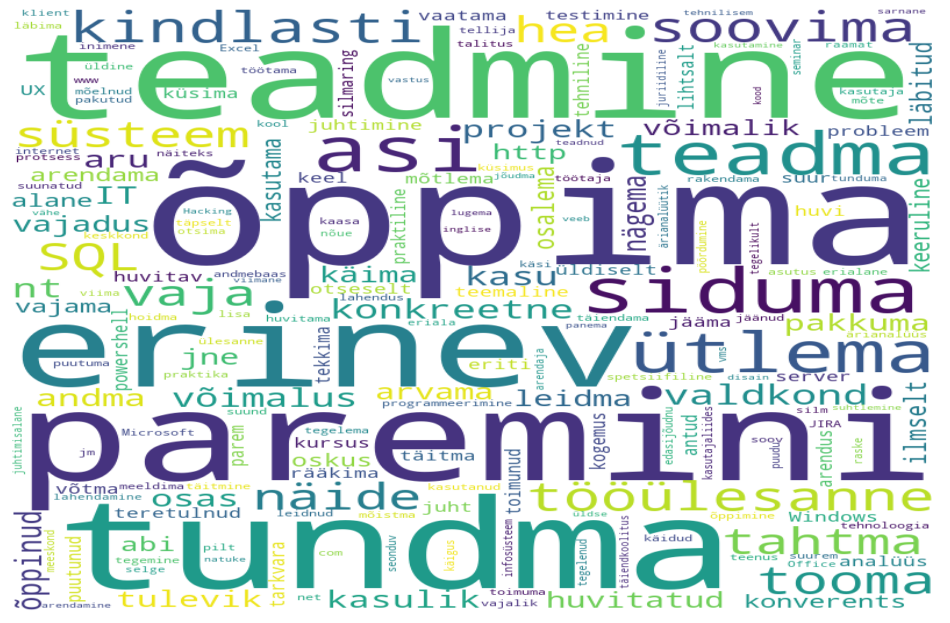

In [39]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# The default for a Wordcloud is that collocations=True, so frequent 
# phrases of two adjacent words are included in the cloud and result is "muutunud muutunud"
# collocations=False result is just "muutunud"
wordcloud = WordCloud(collocations=False ,width=800, height=800,
                      background_color='white',
                      stopwords=est_stops,
                      min_font_size=10)

wordcloud.generate(wordsText)
# If you look at wordcloud.words_ you will see the frequency table'
# print(wordcloud.words_)

# Display the generated Word Cloud
plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
plt.axis("off")
# make plot bigger
#plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
plt.show()